In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics
from scipy.stats import mannwhitneyu
from bs4 import BeautifulSoup  
import requests
import string
import pymorphy2
import dask.bag as db
from datetime import datetime
from sklearn.model_selection import train_test_split

# Задача: построить модель количество визитов в больницу
### Загружаем данные

In [3]:
item = 'OFP' # Выбрать из поля Item для вашего датасета
package = 'Ecdat' # Выбрать из поля Package для вашего датасета

data = sm.datasets.get_rdataset(item, package , cache=True).data
data.head()

,ofp,ofnp,opp,opnp,emr,hosp,numchron,adldiff,age,black,sex,maried,school,faminc,employed,privins,medicaid,region,hlth
0,5,0,0,0,0,1,2,0,6.9,yes,male,yes,6,2.8810,yes,yes,no,other,other
1,1,0,2,0,2,0,2,0,7.4,no,female,yes,10,2.7478,no,yes,no,other,other
2,13,0,0,0,3,3,4,1,6.6,yes,female,no,10,0.6532,no,no,yes,other,poor
3,16,0,5,0,1,1,2,1,7.6,no,male,yes,3,0.6588,no,yes,no,other,poor
4,3,0,0,0,0,0,2,1,7.9,no,female,yes,6,0.6588,no,yes,no,other,other


### Вводим новую переменную количество визитов в больницу

In [7]:
data['hosp_v'] = data['ofp'] + data['opp'] + data['opnp'] + data['ofnp'] + data['emr'] + data['hosp']

### Приводим возраст в надлежащий вид (в датасете они разделены на 10)

In [10]:
data['age'] = data['age']*10
data['age'] = data['age'].round().astype(int)

### Просмотрим структуру нашего df и определим есть ли пропуски

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4406 entries, 0 to 4405
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ofp       4406 non-null   int64  
 1   ofnp      4406 non-null   int64  
 2   opp       4406 non-null   int64  
 3   opnp      4406 non-null   int64  
 4   emr       4406 non-null   int64  
 5   hosp      4406 non-null   int64  
 6   numchron  4406 non-null   int64  
 7   adldiff   4406 non-null   int64  
 8   age       4406 non-null   int32  
 9   black     4406 non-null   object 
 10  sex       4406 non-null   object 
 11  maried    4406 non-null   object 
 12  school    4406 non-null   int64  
 13  faminc    4406 non-null   float64
 14  employed  4406 non-null   object 
 15  privins   4406 non-null   object 
 16  medicaid  4406 non-null   object 
 17  region    4406 non-null   object 
 18  hlth      4406 non-null   object 
 19  hosp_v    4406 non-null   int64  
dtypes: float64(1), int32(1), int64

In [15]:
# Пропусков нет.

In [17]:
data

,ofp,ofnp,opp,opnp,emr,hosp,numchron,adldiff,age,black,sex,maried,school,faminc,employed,privins,medicaid,region,hlth,hosp_v
0,5,0,0,0,0,1,2,0,69,yes,male,yes,6,2.881000,yes,yes,no,other,other,6
1,1,0,2,0,2,0,2,0,74,no,female,yes,10,2.747800,no,yes,no,other,other,5
2,13,0,0,0,3,3,4,1,66,yes,female,no,10,0.653200,no,no,yes,other,poor,19
3,16,0,5,0,1,1,2,1,76,no,male,yes,3,0.658800,no,yes,no,other,poor,23
4,3,0,0,0,0,0,2,1,79,no,female,yes,6,0.658800,no,yes,no,other,other,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4401,11,0,0,0,0,0,0,0,84,no,female,yes,8,2.249700,no,yes,no,other,other,11
4402,12,0,0,0,0,0,2,0,78,no,female,no,11,5.813200,no,yes,no,other,other,12
4403,10,0,20,0,1,1,5,0,73,no,male,yes,12,3.877916,no,yes,no,other,other,32
4404,16,1,0,0,0,0,0,0,66,no,female,yes,12,3.877916,no,yes,no,other,other,17


### Так как старый мой датасет не имеет описания делаем разведочный анализ на новый датасет

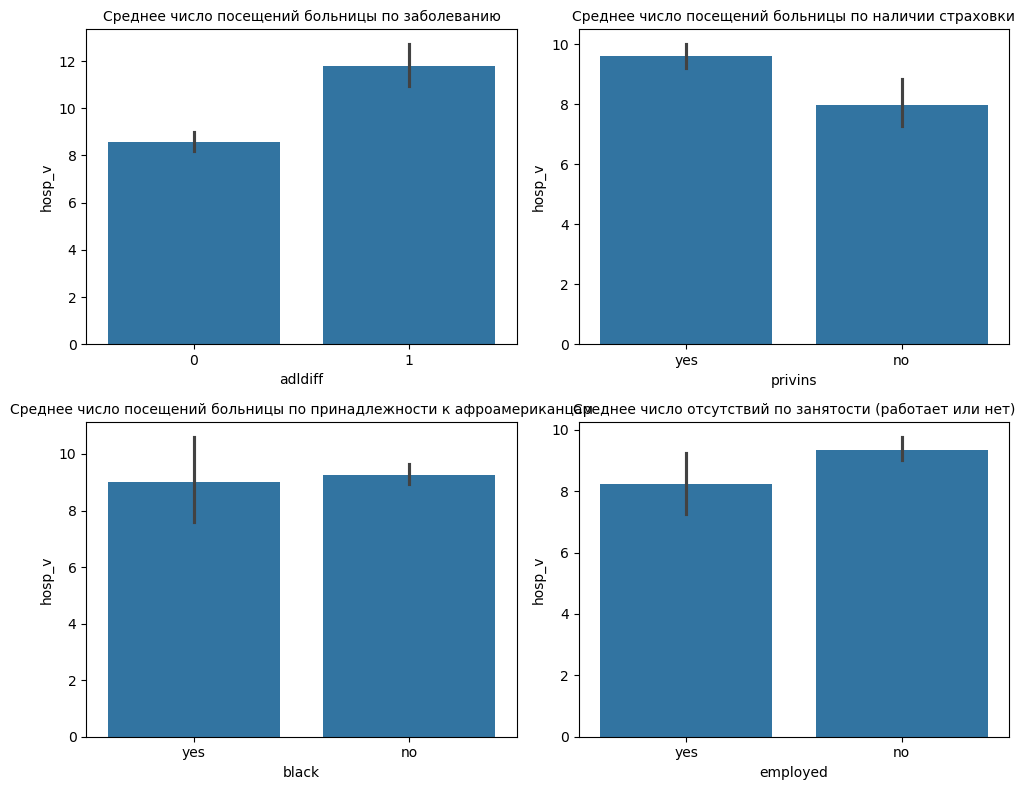

In [20]:
fig, ax = plt.subplots(2,2, figsize = (10,8))
sns.barplot(x = 'adldiff', y = 'hosp_v', data = data, ax = ax[0,0])
ax[0,0].set_title('Среднее число посещений больницы по заболеванию', fontsize = 10)
sns.barplot(x = 'privins', y = 'hosp_v', data = data, ax = ax[0, 1])
ax[0,1].set_title('Среднее число посещений больницы по наличии страховки', fontsize = 10)
sns.barplot(x = 'black', y = 'hosp_v', data = data, ax = ax[1, 0])
ax[1,0].set_title('Среднее число посещений больницы по принадлежности к афроамериканцам', fontsize = 10)
sns.barplot(x = 'employed', y = 'hosp_v', data = data, ax = ax[1,1])
ax[1,1].set_title('Среднее число отсутствий по занятости (работает или нет)', fontsize = 10)
plt.tight_layout()
plt.show()

In [22]:
# Наличие заболевания ограничевающего деятельность, страховки, и занятость могут быть приемлемыми переменными для предсказания количества посещений болььницы

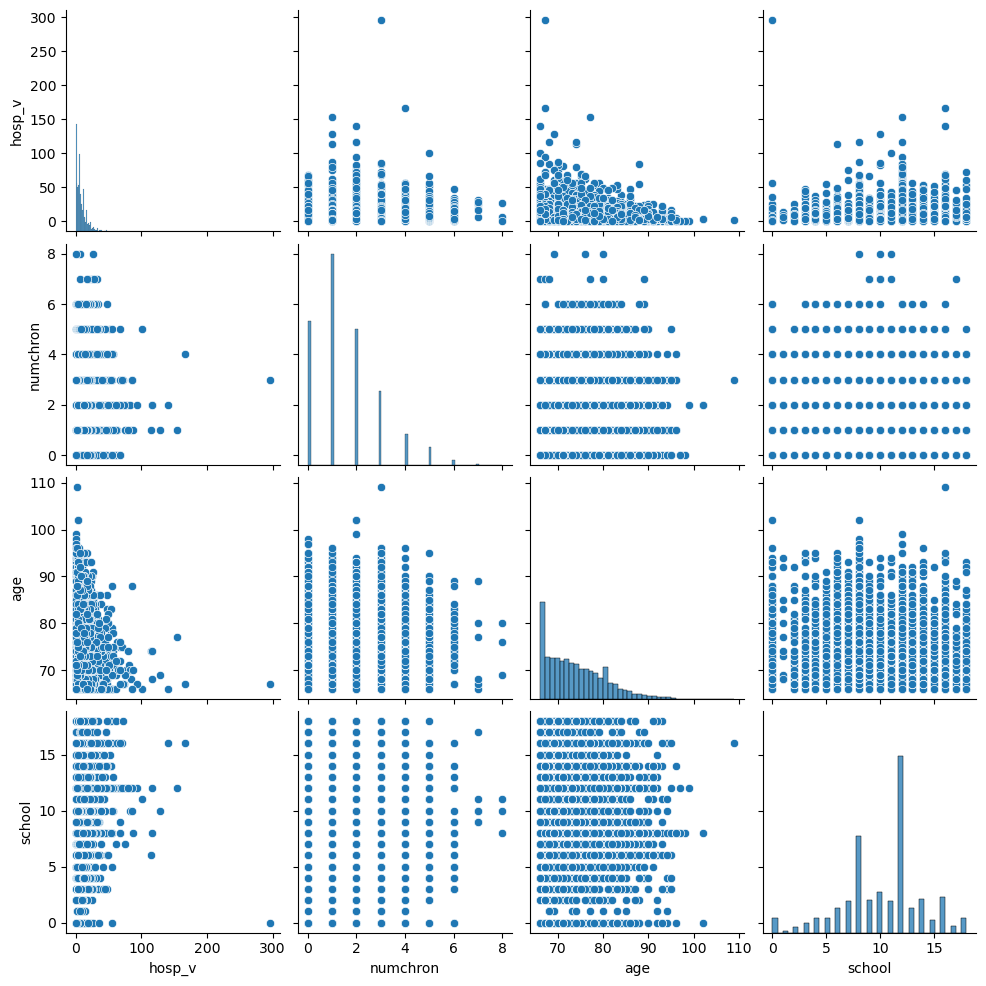

In [24]:
sns.pairplot(data[['hosp_v', 'numchron', 'age', 'school']])

### Убираем выбросы по количеству походов

In [26]:
 data['hosp_v'].describe()

count    4406.000000
mean        9.238765
std        12.198796
min         0.000000
25%         2.000000
50%         6.000000
75%        12.000000
max       296.000000
Name: hosp_v, dtype: float64

In [27]:
 q1 = data['hosp_v'].quantile(0.25)
 q3 = data['hosp_v'].quantile(0.75)
 iqr = q3 - q1
 data = data[(data['hosp_v']>=q1 - 1.5*iqr)&(data['hosp_v']<=q1 + 1.5*iqr)]# data.shape

In [28]:
 data['hosp_v'].describe()

count    3821.000000
mean        5.909710
std         4.611784
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        17.000000
Name: hosp_v, dtype: float64

### Переводим категориальные переменные в числовой формат (бинарные переменные)

In [34]:
#cat_hos = ['adldiff', 'privins', 'black', 'employed' ]
cat_hos = ['adldiff']
# num_chos = ['numchron', 'age', 'school']
num_chos = ['numchron', 'age']
target_hos = ['hosp_v']

### Готовим матрицу X и вектор y

In [37]:
X_dummies = pd.get_dummies(data[cat_hos], drop_first = True, dtype = int)
X_dummies.head()

,adldiff
0,0
1,0
4,1
5,1
6,0


In [39]:
X = data[num_chos]
X = pd.merge(
    left = X,
    right = X_dummies,
    how = 'inner',
    left_index = True,
    right_index = True
)

y = data[target_hos]

In [41]:
X

,numchron,age,adldiff
0,2,69,0
1,2,74,0
4,2,79,1
5,5,66,1
6,0,75,0
...,...,...,...
4400,3,82,0
4401,0,84,0
4402,2,78,0
4404,0,66,0


### Делим выборку на обучающую, тестовую и прогнозную

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [46]:
X_train.shape

(2292, 3)

In [48]:
X_test.shape

(1529, 3)

In [50]:
X_test, X_forecast, y_test, y_forecast = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [52]:
X_test.shape

(764, 3)

In [54]:
X_forecast.shape

(765, 3)

In [66]:
y_test

,hosp_v
3875,6
2950,0
485,2
2419,10
3740,7
...,...
3662,9
866,0
4345,8
3739,4


### Обучаем модель 

#### Linear Regression (OLS)

In [58]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [60]:
y_pred = ols.predict(X_test)

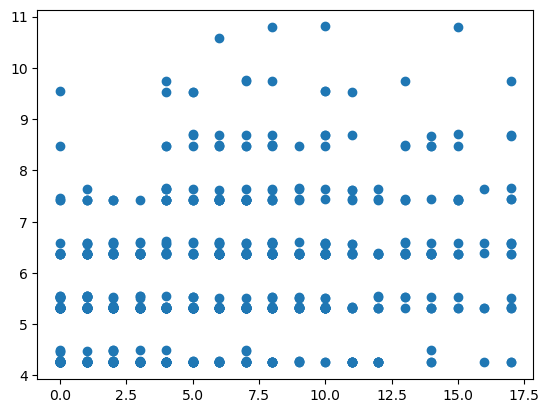

In [62]:
plt.scatter(y_test, y_pred)
plt.show()

In [64]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred))

R2 0.10885582570077057
MAE 3.4283656801510007
RMSE 4.210310193774052
MAPE 2775044872884272.0


### Пробуем другие модели регрессии

#### SVM

In [72]:
from sklearn import svm
regr_svm = svm.SVR()
regr_svm.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

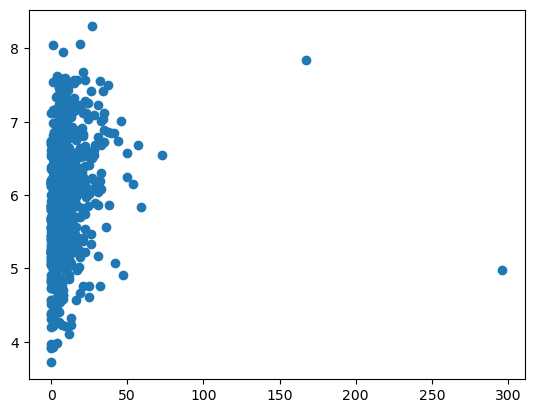

In [74]:
y_pred = regr_svm.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()

In [76]:
print('R2', r2_score(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred))

R2 -0.036442493000235165
MAE 6.4201267349944775
RMSE 14.500879346646466
MAPE 2637848785363195.0


### SGD

In [79]:
from sklearn.linear_model import SGDRegressor
regr_sgd = SGDRegressor()
regr_sgd.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor()

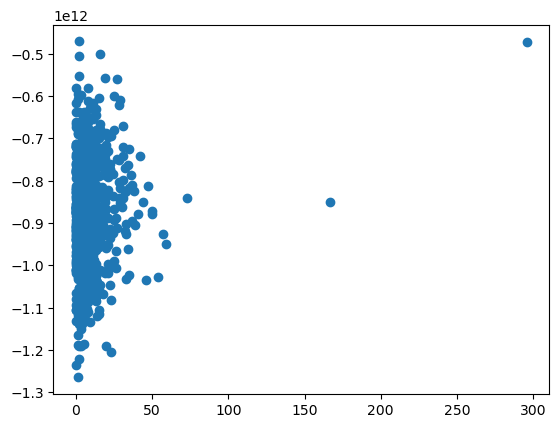

In [81]:
y_pred = regr_sgd.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()